# Proyecto Semestral: Introducción a Redes Neuronales y Deep Learning

En este documento se aplica, con la mayor fidelidad posible lo abordado en el paper. El código esta separado en las siguientes secciones. 

## Imports

In [2]:
# ==========================================================
# IMPORTS
# ==========================================================
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Optional, Sequence, Mapping, Union

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, Sequential

import matplotlib.pyplot as plt
import seaborn as sns


## Generación del dataset

* Indicadores técnicos
* Target(y) y splits temporales
* Escalado y construcción de ventanas 

In [ ]:
def make_tech_indicators(
    data,
    price_col: str = "Close",
    high_col: str = "High",
    low_col: str = "Low",
    vol_col: str = "Volume",
    safe: bool = True,
    reset_index: bool = True
) -> pd.DataFrame:
    """
    Genera un conjunto completo de indicadores técnicos financieros a partir de datos OHLCV.
    
    Calcula más de 40 indicadores técnicos incluyendo medias móviles, osciladores,
    indicadores de momentum, volatilidad y volumen. Todos los indicadores se calculan
    de forma que eviten fuga de datos temporal.
    
    Parameters
    ----------
    data : pd.Series or pd.DataFrame
        Datos de entrada. Puede ser una Serie con precios de cierre o un DataFrame
        con columnas OHLCV (Open, High, Low, Close, Volume).
    price_col : str, default="Close"
        Nombre de la columna que contiene el precio de cierre.
    high_col : str, default="High"
        Nombre de la columna que contiene el precio máximo.
    low_col : str, default="Low"
        Nombre de la columna que contiene el precio mínimo.
    vol_col : str, default="Volume"
        Nombre de la columna que contiene el volumen.
    safe : bool, default=True
        Si True, desplaza todos los features 1 día hacia adelante para evitar
        fuga de datos (anti-fuga). Esto asegura que para predecir t+1 solo se
        use información hasta t.
    reset_index : bool, default=True
        Si True, convierte el índice datetime en una columna "Date" y resetea el índice.
        Si False, mantiene el índice como DatetimeIndex.
    
    Returns
    -------
    pd.DataFrame
        DataFrame con columnas:
        - Date: Fecha (si reset_index=True)
        - Price: Precio de cierre
        - Open, High, Low, Volume: Datos originales (si disponibles)
        - SMA_5, SMA_10, SMA_20, SMA_50, SMA_200: Medias móviles simples
        - EMA_5, EMA_10, EMA_20, EMA_50: Medias móviles exponenciales
        - MACD, MACD_signal, MACD_hist: Indicadores MACD
        - ROC_1, ROC_5, ROC_10: Rate of Change
        - MOM_1, MOM_5, MOM_10: Momentum
        - RSI_14: Relative Strength Index
        - VOL_20: Volatilidad logarítmica
        - BB_BW, BB_PB: Bollinger Bands (ancho y posición)
        - STOCH_K, STOCH_D: Estocástico
        - WILLR_14: Williams %R
        - CCI_20: Commodity Channel Index
        - ATR_14, ADX_14: Average True Range y Average Directional Index
        - PLUS_DI, MINUS_DI: Directional Indicators
        - OBV: On-Balance Volume
        - MFI_14: Money Flow Index
        - BIAS_12, PSY_12, BBI: Indicadores adicionales
        - CHO_3_10: Chaikin Oscillator
        - MASS_25: Mass Index
        - WVAD_24: Williams' Volume Accumulation/Distribution
        - AR_26, BR_26, CR_26: Indicadores de momentum con volumen
    
    Notes
    -----
    - Los indicadores que requieren High/Low o Volume devuelven NaN si esos datos
      no están disponibles.
    - Todos los valores infinitos se reemplazan por NaN y luego se eliminan las filas
      con NaN antes de retornar.
    - El DataFrame resultante está ordenado por fecha de forma ascendente.
    
    Examples
    --------
    >>> import pandas as pd
    >>> data = pd.read_csv("stock_data.csv", index_col="Date", parse_dates=True)
    >>> features = make_tech_indicators(data, safe=True)
    >>> print(features.columns.tolist()[:10])
    ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'SMA_5', 'SMA_10', ...]
    """

    # ---------- Normalización de entrada ----------
    if isinstance(data, pd.Series):
        df = data.to_frame(name=price_col).copy()
    else:
        df = data.copy()

    if df.index.name is None:
        df.index.name = "Date"
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Asegura columnas esperadas y dtypes
    for c in [price_col, high_col, low_col, vol_col]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")
    if price_col not in df.columns:
        raise ValueError(f"Falta columna de precio '{price_col}'")

    has_hl = (high_col in df.columns) and (low_col in df.columns)
    has_vol = vol_col in df.columns

    # Alias locales
    close = df[price_col]
    high  = df[high_col] if has_hl else None
    low   = df[low_col]  if has_hl else None
    vol   = df[vol_col].replace(0, np.nan).astype("float64") if has_vol else None

    # ---------- Helpers internos ----------
    ema = lambda s, span: s.ewm(span=span, adjust=False).mean()

    def true_range():
        prev_close = close.shift(1)
        tr1 = (high - low) if has_hl else (close - close) * np.nan
        tr2 = (high - prev_close).abs() if has_hl else (close - prev_close).abs()
        tr3 = (low - prev_close).abs() if has_hl else (prev_close - close).abs()
        return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    def rsi(n=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        return (100 - (100 / (1 + rs))).fillna(50.0)

    def stochastic(n=14, d=3):
        if not has_hl:
            return pd.Series(np.nan, index=df.index), pd.Series(np.nan, index=df.index)
        low_n = low.rolling(n).min()
        high_n = high.rolling(n).max()
        den = (high_n - low_n).replace(0, np.nan)
        k = 100 * (close - low_n) / den
        dline = k.rolling(d).mean()
        return k, dline

    def bollinger(n=20, k=2):
        ma = close.rolling(n).mean()
        sd = close.rolling(n).std()
        upper, lower = ma + k*sd, ma - k*sd
        bw = (upper - lower) / ma
        den = (upper - lower).replace(0, np.nan)
        pb = (close - lower) / den
        return bw, pb

    def adx_block(n=14):
        if not has_hl:
            nan = pd.Series(np.nan, index=df.index)
            return nan, nan, nan, nan
        up_move = high.diff()
        down_move = -low.diff()
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
        tr = true_range()
        atr = tr.ewm(alpha=1/n, adjust=False).mean().replace(0, np.nan)
        plus_di = 100 * pd.Series(plus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        minus_di = 100 * pd.Series(minus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        den = (plus_di + minus_di).replace(0, np.nan)
        dx = 100 * (plus_di - minus_di).abs() / den
        adx = dx.ewm(alpha=1/n, adjust=False).mean()
        return atr, adx, plus_di, minus_di

    def obv():
        if not has_vol:
            return pd.Series(np.nan, index=df.index)
        return (np.sign(close.diff()).fillna(0) * vol.fillna(0)).cumsum()

    def mfi(n=14):
        if not (has_hl and has_vol):
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        mf = tp * vol.fillna(0.0)
        pos_flow = np.where(tp > tp.shift(1), mf, 0.0)
        neg_flow = np.where(tp < tp.shift(1), mf, 0.0)
        pos = pd.Series(pos_flow, index=df.index, dtype="float64").rolling(n).sum()
        neg = pd.Series(neg_flow, index=df.index, dtype="float64").rolling(n).sum()
        mfr = pos / neg.replace(0, np.nan)
        return (100 - (100 / (1 + mfr))).fillna(50.0)

    def cci(n=20):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        sma = tp.rolling(n).mean()
        mad = (tp - sma).abs().rolling(n).mean()
        return (tp - sma) / (0.015 * mad)

    def williams_r(n=14):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        hh = high.rolling(n).max()
        ll = low.rolling(n).min()
        denom = (hh - ll).replace(0, np.nan)
        return -100 * (hh - close) / denom

    # ---------- Cálculo de indicadores ----------
    out = pd.DataFrame(index=df.index)
    out["Price"] = close.astype("float64")

    out["Open"]   = df["Open"].astype("float64") if "Open" in df.columns else np.nan
    out["High"]   = high if has_hl else np.nan
    out["Low"]    = low if has_hl else np.nan
    out["Volume"] = df[vol_col] if has_vol else np.nan

    # Tendencia
    for n in [5, 10, 20, 50, 200]:
        out[f"SMA_{n}"] = close.rolling(n).mean()
    for n in [5, 10, 20, 50]:
        out[f"EMA_{n}"] = ema(close, n)

    macd = ema(close, 12) - ema(close, 26)
    macd_sig = ema(macd, 9)
    out["MACD"]        = macd
    out["MACD_signal"] = macd_sig
    out["MACD_hist"]   = macd - macd_sig

    # Momentum
    for h in [1, 5, 10]:
        out[f"ROC_{h}"] = (close - close.shift(h)) / close.shift(h)
        out[f"MOM_{h}"] = close - close.shift(h)
    out["RSI_14"] = rsi(14)

    # Volatilidad y bandas
    out["VOL_20"] = np.log(close / close.shift(1)).rolling(20).std()
    bw, pb = bollinger(20, 2)
    out["BB_BW"] = bw
    out["BB_PB"] = pb

    # Osciladores con H/L
    k, d = stochastic(14, 3)
    out["STOCH_K"]  = k
    out["STOCH_D"]  = d
    out["WILLR_14"] = williams_r(14)
    out["CCI_20"]   = cci(20)

    # Rango y dirección
    atr, adx, plus_di, minus_di = adx_block(14)
    out["ATR_14"]   = atr
    out["ADX_14"]   = adx
    out["PLUS_DI"]  = plus_di
    out["MINUS_DI"] = minus_di

    # Flujo / volumen
    out["OBV"]     = obv()
    out["MFI_14"]  = mfi(14)

    # Extras
    out["BIAS_12"] = (close - close.rolling(12).mean()) / close.rolling(12).mean()
    updays = (close.diff() > 0).astype(int)
    out["PSY_12"] = 100 * updays.rolling(12).mean()
    out["BBI"] = (
        close.rolling(3).mean()
        + close.rolling(6).mean()
        + close.rolling(12).mean()
        + close.rolling(24).mean()
    ) / 4.0

    # CHO (Chaikin Oscillator)
    if has_hl and has_vol:
        clv = ((close - low) - (high - close)) / (high - low)
        clv = clv.replace([np.inf, -np.inf], np.nan).fillna(0)
        adl = (clv * vol.fillna(0)).cumsum()
        out["CHO_3_10"] = ema(adl, 3) - ema(adl, 10)
    else:
        out["CHO_3_10"] = np.nan

    # MASS / WVAD / AR-BR / CR
    if has_hl:
        diff_hl = (high - low).abs()
        e1 = diff_hl.ewm(span=9, adjust=False).mean()
        e2 = e1.ewm(span=9, adjust=False).mean()
        ratio = e1 / e2.replace(0, np.nan)
        out["MASS_25"] = ratio.rolling(25).sum()
    else:
        out["MASS_25"] = np.nan

    if has_hl and has_vol:
        rng = (high - low).replace(0, np.nan)
        out["WVAD_24"] = (((close - df.get("Open", close)) / rng) * vol).rolling(24).sum()

        ar_num = (high - df.get("Open", close)).rolling(26).sum()
        ar_den = (df.get("Open", close) - low).rolling(26).sum().replace(0, np.nan)
        out["AR_26"] = 100 * ar_num / ar_den

        cp = close.shift(1)
        br_num = (high - cp).rolling(26).sum()
        br_den = (cp - low).rolling(26).sum().replace(0, np.nan)
        out["BR_26"] = 100 * br_num / br_den

        mid   = (high + low + 2*close) / 4
        mid_y = mid.shift(1)
        up    = (high - mid_y).clip(lower=0)
        down  = (mid_y - low).clip(lower=0)
        out["CR_26"] = 100 * up.rolling(26).sum() / down.rolling(26).sum().replace(0, np.nan)
    else:
        out["WVAD_24"] = np.nan
        out["AR_26"]   = np.nan
        out["BR_26"]   = np.nan
        out["CR_26"]   = np.nan

    # ---------- Anti-fuga ----------
    if safe:
        feat_cols = [c for c in out.columns if c != "Price"]
        out[feat_cols] = out[feat_cols].shift(1)

    # ---------- Limpieza ----------
    out = out.astype("float64")
    out = out.replace([np.inf, -np.inf], np.nan)
    out = out.dropna().copy()

    if reset_index:
        out = out.rename_axis("Date").reset_index()

    return out

@dataclass
class SplitDates:
    """
    Almacena las fechas de corte para dividir datos temporales en train, validation y test.
    
    Attributes
    ----------
    train_end : str
        Fecha de fin del conjunto de entrenamiento (inclusive), formato "YYYY-MM-DD".
    val_end : str
        Fecha de fin del conjunto de validación (inclusive), formato "YYYY-MM-DD".
    test_end : Optional[str], default=None
        Fecha de fin del conjunto de test (inclusive), formato "YYYY-MM-DD".
        Si es None, el conjunto de test incluye todo desde val_end hasta el final.
    
    Examples
    --------
    >>> splits = SplitDates(
    ...     train_end="2020-12-31",
    ...     val_end="2021-06-30",
    ...     test_end="2021-12-31"
    ... )
    """
    train_end: str
    val_end: str
    test_end: Optional[str] = None
    
    @classmethod
    def from_ratios(cls, X_y: pd.DataFrame, train_ratio: float, val_ratio: float):
        """
        Crea splits basados en proporciones del índice temporal.
        
        Divide los datos temporalmente según las proporciones especificadas:
        - Train: desde el inicio hasta train_ratio del total
        - Validation: desde train_ratio hasta (train_ratio + val_ratio) del total
        - Test: desde (train_ratio + val_ratio) hasta el final
        
        Parameters
        ----------
        X_y : pd.DataFrame
            DataFrame con índice DatetimeIndex ordenado de forma ascendente.
        train_ratio : float
            Proporción de datos para entrenamiento (0.0 a 1.0).
            Ejemplo: 0.7 significa 70% de los datos.
        val_ratio : float
            Proporción de datos para validación (0.0 a 1.0).
            Ejemplo: 0.1 significa 10% de los datos.
        
        Returns
        -------
        SplitDates
            Instancia de SplitDates con las fechas calculadas.
        
        Notes
        -----
        - El índice de X_y DEBE ser un DatetimeIndex ordenado.
        - train_ratio + val_ratio debe ser <= 1.0
        - Si train_ratio + val_ratio = 1.0, test_end será None.
        
        Examples
        --------
        >>> X_y = pd.DataFrame(index=pd.date_range("2020-01-01", "2021-12-31", freq="D"))
        >>> splits = SplitDates.from_ratios(X_y, train_ratio=0.7, val_ratio=0.1)
        >>> print(splits.train_end, splits.val_end)
        """
        idx = X_y.index
        n = len(idx)
        
        # Posiciones en enteros
        
        pos_train_end = int(n*train_ratio) 
        pos_val_end = int(n*(train_ratio + val_ratio))
        
        pos_train_end = min(max(pos_train_end,0),n-1)
        pos_val_end = min(max(pos_val_end,0),n-1)
        
        # Convertir posiciones a fechas
        train_end_date = idx[pos_train_end].strftime("%Y-%m-%d")
        val_end_date = idx[pos_val_end].strftime("%Y-%m-%d")
        
        if pos_val_end == n-1:
            test_end_date = None
        else: 
            test_end_date = idx[-1].strftime("%Y-%m-%d")
            
        return cls(
                   train_end=train_end_date,
                   val_end=val_end_date,
                   test_end=test_end_date
        )


def build_xy(features_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """
    Construye las matrices X (features) e y (target) a partir de features técnicos.
    
    El target y es el precio del siguiente período (Price_next = Price(t+1)),
    mientras que X contiene todos los features disponibles en el período actual.
    Elimina automáticamente columnas constantes que no aportan información.
    
    Parameters
    ----------
    features_df : pd.DataFrame
        DataFrame con features técnicos. Debe contener una columna "Price" y
        opcionalmente una columna "Date". Si tiene "Date", se usa como índice.
    
    Returns
    -------
    tuple[pd.DataFrame, pd.Series]
        Tupla (X, y) donde:
        - X: DataFrame con todas las columnas de features (incluyendo Price).
              El índice es DatetimeIndex ordenado.
        - y: Series con el precio del siguiente período (Price_next).
              El índice coincide con X (excepto la última fila que se elimina).
    
    Notes
    -----
    - Elimina automáticamente columnas constantes (con un solo valor único).
    - Elimina filas con NaN resultantes del shift.
    - X e y tienen índices alineados.
    
    Examples
    --------
    >>> features = make_tech_indicators(data)
    >>> X, y = build_xy(features)
    >>> print(f"X shape: {X.shape}, y shape: {y.shape}")
    >>> print(f"Target: precio del día siguiente")
    """
    df = features_df.copy()
    if "Date" in df.columns: # Hacer de índice si está como columna
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date").sort_index()

    df["Price_next"] = df["Price"].shift(-1)  # Price(t+1)
    df = df.dropna()

    y = df["Price_next"].astype(float)
    X = df.drop(columns=["Price_next"])

    const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1] # columnas constantes
    if const_cols:
        X = X.drop(columns=const_cols)

    assert X.index.equals(y.index)
    return X, y



def time_splits(
    X: pd.DataFrame, 
    y: pd.Series, 
    dates: SplitDates
) -> tuple[tuple[pd.DataFrame, pd.Series], tuple[pd.DataFrame, pd.Series], tuple[pd.DataFrame, pd.Series]]:
    """
    Divide los datos en conjuntos de train, validation y test según fechas especificadas.
    
    Realiza una división temporal estricta respetando el orden cronológico.
    No hay solapamiento entre los conjuntos y se mantiene el orden temporal.
    
    Parameters
    ----------
    X : pd.DataFrame
        DataFrame con features. Debe tener un índice DatetimeIndex.
    y : pd.Series
        Series con el target. Debe tener el mismo índice que X.
    dates : SplitDates
        Objeto con las fechas de corte para train, validation y test.
    
    Returns
    -------
    tuple
        Tupla de tres elementos, cada uno es una tupla (X_subset, y_subset):
        - ((X_train, y_train), (X_val, y_val), (X_test, y_test))
        
        Donde:
        - X_train, y_train: Datos hasta dates.train_end (inclusive)
        - X_val, y_val: Datos desde dates.train_end (exclusive) hasta dates.val_end (inclusive)
        - X_test, y_test: Datos desde dates.val_end (exclusive) hasta dates.test_end
          (o hasta el final si dates.test_end es None)
    
    Notes
    -----
    - Las divisiones son inclusivas en el extremo superior según las fechas especificadas.
    - No hay mezcla temporal entre conjuntos.
    - X e y deben tener índices alineados.
    
    Examples
    --------
    >>> splits = SplitDates(train_end="2020-12-31", val_end="2021-06-30")
    >>> (X_train, y_train), (X_val, y_val), (X_test, y_test) = time_splits(X, y, splits)
    >>> print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    """
    idx = X.index
    train = idx <= pd.to_datetime(dates.train_end)
    val   = (idx > pd.to_datetime(dates.train_end)) & (idx <= pd.to_datetime(dates.val_end))
    test  = idx > pd.to_datetime(dates.val_end) if dates.test_end is None else (
            (idx > pd.to_datetime(dates.val_end)) & (idx <= pd.to_datetime(dates.test_end)))
    return (X.loc[train], y.loc[train]), (X.loc[val], y.loc[val]), (X.loc[test], y.loc[test])


class TimeScaler:
    """
    Escalador MinMax para features X que respeta el orden temporal.
    
    Aplica escalado MinMax solo sobre datos de entrenamiento para evitar
    fuga de datos temporal. El fit se hace únicamente con datos de train,
    y luego se aplica la misma transformación a validation y test.
    
    Attributes
    ----------
    scaler : MinMaxScaler
        Escalador de sklearn que realiza la transformación MinMax.
    cols_ : list[str]
        Lista de columnas que se usaron durante el fit. Se guarda para
        asegurar consistencia en transformaciones posteriores.
    
    Examples
    --------
    >>> scaler = TimeScaler(feature_range=(0, 1))
    >>> scaler.fit(X_train)
    >>> X_train_scaled = scaler.transform(X_train)
    >>> X_val_scaled = scaler.transform(X_val)
    >>> X_test_scaled = scaler.transform(X_test)
    """
    def __init__(self, feature_range=(0, 1)):
        """
        Inicializa el escalador.
        
        Parameters
        ----------
        feature_range : tuple, default=(0, 1)
            Rango deseado para los datos escalados (min, max).
        """
        self.scaler = MinMaxScaler(feature_range=feature_range)
        self.cols_: list[str] = []

    def fit(self, X_train: pd.DataFrame) -> "TimeScaler":
        """
        Ajusta el escalador usando solo datos de entrenamiento.
        
        Calcula los parámetros de escalado (min, max) a partir de X_train
        y guarda el orden de las columnas para transformaciones futuras.
        
        Parameters
        ----------
        X_train : pd.DataFrame
            DataFrame con features de entrenamiento. Debe tener columnas nombradas.
        
        Returns
        -------
        TimeScaler
            Retorna self para permitir method chaining.
        
        Notes
        -----
        - Los parámetros calculados se usan para todas las transformaciones
          posteriores (val, test), evitando fuga de datos temporal.
        """
        self.scaler.fit(X_train.values)
        self.cols_ = list(X_train.columns)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        """
        Transforma los datos usando los parámetros calculados en fit.
        
        Aplica la misma transformación MinMax calculada en fit a nuevos datos.
        Verifica que las columnas coincidan con las usadas durante el fit.
        
        Parameters
        ----------
        X : pd.DataFrame
            DataFrame con features a transformar. Debe contener las mismas
            columnas que se usaron en fit (puede tener columnas extra que
            se ignoran).
        
        Returns
        -------
        np.ndarray
            Array numpy con los datos escalados. Shape: (n_samples, n_features).
        
        Raises
        ------
        AssertionError
            Si faltan columnas que se usaron durante el fit.
        
        Notes
        -----
        - Si X tiene columnas extra, se muestran un aviso pero no se lanza error.
        - Las columnas se reordenan según el orden guardado en fit.
        """
        missing = [c for c in self.cols_ if c not in X.columns]
        extra   = [c for c in X.columns if c not in self.cols_]
        assert not missing, f"Faltan columnas para transformar: {missing}"
        if extra:
            print(f"[AVISO] Columnas extra ignoradas en transform: {extra}")
        X2 = X[self.cols_].values
        return self.scaler.transform(X2)


class TimeScalerY:
    """
    Escalador MinMax para el target y que respeta el orden temporal.
    
    Similar a TimeScaler pero diseñado específicamente para el target (y).
    Permite transformar e invertir la transformación para recuperar valores
    en escala original.
    
    Attributes
    ----------
    scaler : MinMaxScaler
        Escalador de sklearn que realiza la transformación MinMax.
    
    Examples
    --------
    >>> scaler_y = TimeScalerY()
    >>> scaler_y.fit(y_train)
    >>> y_train_scaled = scaler_y.transform(y_train)
    >>> y_pred_scaled = model.predict(X_test)
    >>> y_pred = scaler_y.inverse(y_pred_scaled)  # Volver a escala original
    """
    def __init__(self):
        """Inicializa el escalador con rango por defecto (0, 1)."""
        self.scaler = MinMaxScaler()

    def fit(self, y_train: np.ndarray) -> "TimeScalerY":
        """
        Ajusta el escalador usando solo datos de entrenamiento del target.
        
        Parameters
        ----------
        y_train : np.ndarray
            Array 1D con valores del target de entrenamiento.
        
        Returns
        -------
        TimeScalerY
            Retorna self para permitir method chaining.
        """
        self.scaler.fit(y_train.reshape(-1, 1))
        return self

    def transform(self, y: np.ndarray) -> np.ndarray:
        """
        Transforma el target a escala normalizada.
        
        Parameters
        ----------
        y : np.ndarray
            Array 1D con valores del target a escalar.
        
        Returns
        -------
        np.ndarray
            Array 1D con valores escalados en rango [0, 1] (por defecto).
        """
        return self.scaler.transform(y.reshape(-1, 1)).flatten()

    def inverse(self, y_scaled: np.ndarray) -> np.ndarray:
        """
        Invierte la transformación para recuperar valores en escala original.
        
        Útil para convertir predicciones escaladas de vuelta a la escala
        original de precios (por ejemplo, dólares).
        
        Parameters
        ----------
        y_scaled : np.ndarray
            Array 1D con valores escalados (en rango [0, 1] por defecto).
        
        Returns
        -------
        np.ndarray
            Array 1D con valores en escala original.
        
        Examples
        --------
        >>> y_pred_scaled = model.predict(X_test)  # Predicciones en [0, 1]
        >>> y_pred_real = scaler_y.inverse(y_pred_scaled)  # Predicciones en dólares
        """
        return self.scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()


def make_sequences(
    X_arr: np.ndarray,
    y_arr: np.ndarray,
    dates_arr: np.ndarray,
    lookback: int = 5,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Construye secuencias temporales (ventanas deslizantes) para modelos de series temporales.
    
    Crea ventanas de lookback períodos consecutivos para predecir el valor del target
    en el período actual. Cada muestra usa información de los últimos 'lookback' períodos
    para predecir el valor en t.
    
    Parameters
    ----------
    X_arr : np.ndarray
        Array 2D con features, shape (n_samples, n_features).
        Debe estar ordenado temporalmente.
    y_arr : np.ndarray
        Array 1D con valores del target, shape (n_samples,).
        Debe estar alineado con X_arr.
    dates_arr : np.ndarray
        Array 1D con fechas correspondientes a cada muestra, shape (n_samples,).
    lookback : int, default=5   
        Número de períodos hacia atrás a incluir en cada ventana.
        Cada secuencia tendrá lookback muestras consecutivas.
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray, np.ndarray]
        Tupla (X_seq, y_seq, d_seq) donde:
        - X_seq: Array 3D con secuencias, shape (n_sequences, lookback, n_features).
                 Cada fila es una ventana de lookback períodos consecutivos.
        - y_seq: Array 1D con targets, shape (n_sequences,).
                 y_seq[i] corresponde al target en el período final de X_seq[i].
        - d_seq: Array 1D con fechas, shape (n_sequences,).
                 d_seq[i] es la fecha del período final de la secuencia X_seq[i].
    
    Notes
    -----
    - El número de secuencias resultantes es: n_samples - lookback + 1
    - La primera secuencia usa índices [0:lookback] para predecir y[lookback-1]
    - La última secuencia usa índices [n-lookback:n] para predecir y[n-1]
    - Todas las secuencias tienen exactamente lookback períodos.
    
    Examples
    --------
    >>> X_arr = np.random.rand(100, 10)  # 100 muestras, 10 features
    >>> y_arr = np.random.rand(100)
    >>> dates = pd.date_range("2020-01-01", periods=100)
    >>> X_seq, y_seq, d_seq = make_sequences(X_arr, y_arr, dates, lookback=5)
    >>> print(f"X_seq shape: {X_seq.shape}")  # (96, 5, 10)
    >>> print(f"y_seq shape: {y_seq.shape}")  # (96,)
    """
    n = len(y_arr)
    X_seq, y_seq, d_seq = [], [], []

    for t in range(lookback - 1, n):
        X_seq.append(X_arr[t - lookback + 1:t + 1, :])
        y_seq.append(y_arr[t])
        d_seq.append(dates_arr[t])

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(d_seq),
    )


@dataclass
class LSTMPrepConfig:
    """
    Configuración para preparar datos para modelos LSTM.
    
    Attributes
    ----------
    lookback : int, default=5
        Número de períodos hacia atrás a incluir en cada secuencia.
    horizon : int, default=1
        Horizonte de predicción (solo informativo, no se usa en el código).
    selected_features : Optional[Sequence[str]], default=None
        Lista de nombres de features a usar. Si None, se usan todos los features.
    """
    lookback: int = 5
    horizon: int = 1
    selected_features: Optional[Sequence[str]] = None


def prepare_lstm_data(
    features_df: pd.DataFrame,
    split_dates: SplitDates,
    cfg: LSTMPrepConfig = LSTMPrepConfig(),
) -> dict:
    """
    Prepara datos escalados y secuenciados para modelos LSTM o tabulares.
    
    Realiza el pipeline completo de preparación:
    1. Construye X e y desde features
    2. Selecciona features si se especifica
    3. Divide en train/val/test temporalmente
    4. Escala X e y usando solo datos de train
    5. Construye secuencias temporales (ventanas)
    6. Divide las secuencias en train/val/test
    
    Parameters
    ----------
    features_df : pd.DataFrame
        DataFrame con features técnicos generados por make_tech_indicators.
    split_dates : SplitDates
        Objeto con fechas de corte para train, validation y test.
    cfg : LSTMPrepConfig, default=LSTMPrepConfig()
        Configuración con lookback, horizon y features seleccionados.
    
    Returns
    -------
    dict
        Diccionario con las siguientes claves:
        - "X_train", "X_val", "X_test": Arrays 3D con secuencias, shape (n_samples, lookback, n_features)
        - "y_train", "y_val", "y_test": Arrays 1D con targets escalados
        - "scaler_x": Instancia de TimeScaler ajustada
        - "scaler_y": Instancia de TimeScalerY ajustada
        - "feature_cols": Lista de nombres de features usados
        - "lookback": Valor de lookback usado
        - "horizon": Horizonte de predicción (1)
        - "dates_seq": Array con fechas correspondientes a cada secuencia
    
    Notes
    -----
    - El escalado se hace solo con datos de train para evitar fuga de datos.
    - Las secuencias se construyen antes de dividir, luego se filtran por fecha.
    - Los datos están en escala normalizada [0, 1] (por defecto).
    
    Examples
    --------
    >>> features = make_tech_indicators(data)
    >>> splits = SplitDates.from_ratios(X_y, train_ratio=0.7, val_ratio=0.1)
    >>> cfg = LSTMPrepConfig(lookback=5, selected_features=["RSI_14", "MACD"])
    >>> prep = prepare_lstm_data(features, splits, cfg)
    >>> print(f"X_train shape: {prep['X_train'].shape}")  # (n, 5, 2)
    """
    X, y = build_xy(features_df)

    if cfg.selected_features is not None:
        keep = [c for c in cfg.selected_features if c in X.columns]
        X = X[keep]
        assert list(X.columns) == keep

    (X_tr, y_tr), _, _ = time_splits(X, y, split_dates) # Solo X_tr, y_tr para fit

    scaler_x = TimeScaler().fit(X_tr) # Se usa solo X_tr para fit, así no hay fuga
    X_all_scaled = scaler_x.transform(X)

    y_all    = y.values.astype(np.float32)
    y_tr_arr = y_tr.values.astype(np.float32)

    scaler_y      = TimeScalerY().fit(y_tr_arr)  # Solo y_tr para fit, así no hay fuga
    y_all_scaled  = scaler_y.transform(y_all)
    dates_all     = X.index.to_numpy()

    X_seq, y_seq, d_seq = make_sequences(
        X_all_scaled,
        y_all_scaled,
        dates_all,
        lookback=cfg.lookback,
    )

    train_end_dt = pd.to_datetime(split_dates.train_end)
    val_end_dt   = pd.to_datetime(split_dates.val_end)
    test_end_dt  = pd.to_datetime(split_dates.test_end) if split_dates.test_end is not None else None

    train_mask = d_seq <= train_end_dt
    val_mask   = (d_seq > train_end_dt) & (d_seq <= val_end_dt)
    test_mask  = d_seq > val_end_dt if test_end_dt is None else (
                 (d_seq > val_end_dt) & (d_seq <= test_end_dt))

    Xtr_seq, ytr_seq = X_seq[train_mask], y_seq[train_mask]
    Xva_seq, yva_seq = X_seq[val_mask], y_seq[val_mask]
    Xte_seq, yte_seq = X_seq[test_mask], y_seq[test_mask]

    return {
        "X_train": Xtr_seq,
        "y_train": ytr_seq,
        "X_val":   Xva_seq,
        "y_val":   yva_seq,
        "X_test":  Xte_seq,
        "y_test":  yte_seq,
        "scaler_x":  scaler_x,
        "scaler_y":  scaler_y,
        "feature_cols": list(X.columns),
        "lookback": cfg.lookback,
        "horizon": 1,
        "dates_seq": d_seq,
    }


def prepare_tabular_from_lstm_prep(
    prep_dict: dict
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Convierte secuencias 3D (ventanas temporales) a matrices 2D para modelos tabulares.
    
    Aplana las ventanas temporales en vectores unidimensionales, permitiendo
    usar modelos de sklearn (RandomForest, SVR, etc.) que requieren entrada 2D.
    
    Parameters
    ----------
    prep_dict : dict
        Diccionario retornado por prepare_lstm_data con las claves:
        - "X_train", "X_val", "X_test": Arrays 3D shape (n, lookback, n_features)
        - "y_train", "y_val", "y_test": Arrays 1D
    
    Returns
    -------
    tuple
        Tupla (Xtr, ytr, Xva, yva, Xte, yte) donde:
        - Xtr, Xva, Xte: Arrays 2D shape (n_samples, lookback * n_features)
          Cada fila es una ventana aplanada.
        - ytr, yva, yte: Arrays 1D con targets (sin cambios)
    
    Notes
    -----
    - La transformación es: (n, lookback, n_features) -> (n, lookback * n_features)
    - Útil para usar modelos de sklearn con datos secuenciados sin perder
      la información temporal (se incluye como features adicionales).
    
    Examples
    --------
    >>> prep = prepare_lstm_data(features, splits)
    >>> Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)
    >>> print(f"Xtr shape: {Xtr.shape}")  # (n, lookback * n_features)
    >>> rf = RandomForestRegressor().fit(Xtr, ytr)
    """
    def _flat(Xseq):
        n, L, f = Xseq.shape
        return Xseq.reshape(n, L * f)

    Xtr = _flat(prep_dict["X_train"])
    Xva = _flat(prep_dict["X_val"])
    Xte = _flat(prep_dict["X_test"])
    ytr = prep_dict["y_train"]
    yva = prep_dict["y_val"]
    yte = prep_dict["y_test"]
    return Xtr, ytr, Xva, yva, Xte, yte 


| **Indicador** | **Fórmula** | **Descripción / Interpretación** |
|----------------|-------------|----------------------------------|
| **SMA (Simple Moving Average)** | $ SMA_t = \frac{1}{n}\sum_{i=0}^{n-1} P_{t-i} $ | Promedio simple de precios. Suaviza ruido y muestra tendencia general. |
| **EMA (Exponential Moving Average)** | $ EMA_t = \alpha P_t + (1-\alpha) EMA_{t-1}, \ \alpha = \frac{2}{n+1} $ | Promedio ponderado que da más importancia a precios recientes. |
| **MACD (Moving Average Convergence Divergence)** | $ MACD_t = EMA_{12} - EMA_{26}, \ Signal_t = EMA_9(MACD_t) $ | Mide convergencia/divergencia entre medias móviles; cruces indican cambios de tendencia. |
| **ROC (Rate of Change)** | $ ROC_t = \frac{P_t - P_{t-n}}{P_{t-n}} $ | Tasa de cambio porcentual del precio; mide momentum relativo. |
| **MOM (Momentum)** | $ MOM_t = P_t - P_{t-n} $ | Diferencia absoluta del precio en $n$ periodos; fuerza del movimiento. |
| **RSI (Relative Strength Index)** | $ RSI_t = 100 - \frac{100}{1 + RS}, \ RS = \frac{\text{promedio ganancias}}{\text{promedio pérdidas}} $ | Oscilador 0–100; sobrecompra >70, sobreventa <30. |
| **PSY (Psychological Line)** | $ PSY_t = 100 \times \frac{\#(P_t > P_{t-1})}{n} $ | Porcentaje de días con cierre al alza; mide sentimiento del mercado. |
| **VOL (Volatilidad 20d)** | $ VOL_t = \sigma\left(\ln\frac{P_t}{P_{t-1}}\right)_{20} $ | Desviación estándar de los retornos logarítmicos a 20 días. |
| **Bollinger Bands (BW, PB)** | $ BW = \frac{U-L}{MA}, \ PB = \frac{P-L}{U-L}, \ U=MA+k\sigma, L=MA-k\sigma $ | Ancho de banda (volatilidad) y posición del precio dentro del canal. |
| **Stochastic Oscillator (K, D)** | $ \%K = 100\frac{P - L_n}{H_n - L_n}, \%D = SMA_3(\%K) $ | Relación del cierre actual con el rango de precios reciente; detecta extremos. |
| **Williams %R** | $ \%R = -100\frac{H_n - P}{H_n - L_n} $ | Similar al Stochastic; sobrecompra/sobreventa. |
| **CCI (Commodity Channel Index)** | $ CCI = \frac{TP - SMA(TP)}{0.015 \times MAD(TP)}, \ TP=\frac{H+L+C}{3} $ | Mide la desviación del precio respecto a su promedio típico. |
| **ATR (Average True Range)** | $ ATR = EMA(TR), \ TR=\max(H-L, |H-C_{t-1}|, |L-C_{t-1}|) $ | Volatilidad “real” considerando huecos (gaps). |
| **ADX (Average Directional Index)** | $ ADX = EMA\left(100\frac{|+DI - -DI|}{+DI + -DI}\right) $ | Mide la fuerza de la tendencia (sin dirección). |
| **+DI / -DI (Directional Indicators)** | $ +DI = 100\frac{EMA(+DM)}{ATR}, \ -DI = 100\frac{EMA(-DM)}{ATR} $ | Miden presión compradora (+DI) o vendedora (-DI). |
| **OBV (On-Balance Volume)** | $ OBV_t = OBV_{t-1} + \text{sign}(P_t - P_{t-1})V_t $ | Acumula volumen según dirección del precio; confirma tendencias. |
| **MFI (Money Flow Index)** | $ MFI = 100 - \frac{100}{1 + \frac{\sum MF^+}{\sum MF^-}} $, $ MF=TP\times V $ | RSI ponderado por volumen; mide flujo de dinero. |
| **BIAS** | $ BIAS = \frac{P - SMA_n(P)}{SMA_n(P)} $ | Desviación porcentual del precio respecto a su media. |
| **BBI (Bull and Bear Index)** | $ BBI = \frac{SMA_3 + SMA_6 + SMA_{12} + SMA_{24}}{4} $ | Promedio de 4 SMAs; muestra tendencia de medio plazo. |
| **CHO (Chaikin Oscillator)** | $ CHO = EMA_3(ADL) - EMA_{10}(ADL), \ ADL = \sum (CLV \times V) $ | Detecta acumulación/distribución mediante volumen y rango. |
| **MASS Index** | $ MASS = \sum_{i=0}^{25} \frac{EMA_9(H-L)}{EMA_9(EMA_9(H-L))} $ | Detecta posibles reversiones de tendencia por expansión del rango. |
| **WVAD (Williams Variable A/D)** | $ WVAD = \sum \frac{(C - O)}{H - L} \times V $ | Mide presión de compra/venta combinando rango y volumen. |
| **AR** | $ AR = 100 \frac{\sum(H - O)}{\sum(O - L)} $ | Evalúa fuerza interna de compradores vs. vendedores. |
| **BR** | $ BR = 100 \frac{\sum(H - C_{t-1})}{\sum(C_{t-1} - L)} $ | Evalúa fuerza externa de reacción del mercado. |
| **CR (Energy Index)** | $ CR = 100 \frac{\sum(H - MID_{t-1})}{\sum(MID_{t-1} - L)} $, $ MID=\frac{H+L+2C}{4} $ | Variante que mide presión compradora mediante media desplazada. |

---

### 🧠 Notas
- Todos los indicadores se **desplazan 1 paso (`shift(1)`)** cuando `safe=True`, para evitar fuga temporal.  
- Los que requieren `High`, `Low` o `Volume` devuelven `NaN` si faltan esas columnas.  
- Los primeros valores se pierden por ventanas de cálculo (`rolling`, `EMA`).  
- Todos los resultados son `float64` y listos para modelado o análisis.

## Diseño de Algoritmo Genético

In [ ]:
def evaluar_subset_TS(X: pd.DataFrame, y: pd.Series, mask: np.ndarray, n_splits: int = 5) -> float:
    """
    Evalúa un subset de features usando TimeSeriesSplit y Ridge como función de fitness para el GA.
    
    Calcula el R² medio mediante validación cruzada temporal (TimeSeriesSplit) usando
    un modelo Ridge sobre el subset de features seleccionado por la máscara.
    
    Parameters
    ----------
    X : pd.DataFrame
        DataFrame con todas las features disponibles.
    y : pd.Series
        Series con el target.
    mask : np.ndarray
        Array booleano 1D indicando qué features incluir (True) o excluir (False).
        Debe tener la misma longitud que el número de columnas en X.
    n_splits : int, default=5
        Número de divisiones para TimeSeriesSplit.
    
    Returns
    -------
    float
        R² medio del subset de features. Retorna -1e9 si:
        - El subset tiene menos de 3 features
        - No se pudo calcular el R²
        - El R² no es finito
    
    Notes
    -----
    - Usa StandardScaler + Ridge(alpha=1.0) como modelo base.
    - TimeSeriesSplit respeta el orden temporal de los datos.
    - Esta función se usa como fitness en el algoritmo genético.
    
    Examples
    --------
    >>> mask = np.array([True, False, True, True, False])
    >>> fitness = evaluar_subset_TS(X, y, mask, n_splits=5)
    >>> print(f"Fitness: {fitness}")
    """
    sel_cols = X.columns[mask]
    if len(sel_cols) < 3:
        return -1e9

    Xs = X[sel_cols].values
    ys = y.values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    modelo = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("reg", Ridge(alpha=1.0))
    ])

    r2_list = []
    for tr_idx, te_idx in tscv.split(Xs):
        Xtr, Xte = Xs[tr_idx], Xs[te_idx]
        ytr, yte = ys[tr_idx], ys[te_idx]
        modelo.fit(Xtr, ytr)
        pr = modelo.predict(Xte)
        r2_list.append(r2_score(yte, pr))

    if not r2_list:
        return -1e9

    r2_mean = float(np.mean(r2_list))
    if not np.isfinite(r2_mean):
        r2_mean = -1e9
    return r2_mean


def _multipoint_crossover(p1: np.ndarray, p2: np.ndarray, n_points=2):
    L = len(p1)
    if L < 2:
        return p1.copy(), p2.copy()
    pts = np.sort(np.random.choice(np.arange(1, L), size=min(n_points, max(1, L-1)), replace=False))
    child1, child2 = p1.copy(), p2.copy()
    swap = False
    last = 0
    for pt in list(pts) + [L]:
        if swap:
            child1[last:pt], child2[last:pt] = p2[last:pt], p1[last:pt]
        last = pt
        swap = not swap
    return child1, child2


def _bitflip_mutation(ind: np.ndarray, p=0.003):
    flips = np.random.rand(ind.size) < p
    ind[flips] = ~ind[flips]
    return ind


def _ensure_min_features(ind: np.ndarray, kmin=3):
    on = ind.sum()
    if on < kmin:
        idx0 = np.where(~ind)[0]
        if idx0.size > 0:
            turn_on = np.random.choice(idx0, size=min(kmin-on, idx0.size), replace=False)
            ind[turn_on] = True
    return ind


@dataclass
class GAConfig:
    """
    Configuración para el algoritmo genético de selección de features.
    
    Attributes
    ----------
    pop_size : int, default=20
        Tamaño de la población (número de individuos).
    p_crossover : float, default=0.8
        Probabilidad de realizar crossover entre dos padres.
    p_mutation : float, default=0.003
        Probabilidad de mutación por bit en cada individuo.
    generations : int, default=100
        Número de generaciones a ejecutar.
    n_points_cx : int, default=2
        Número de puntos de corte para crossover multipunto.
    elitism : int, default=0
        Número de mejores individuos a preservar directamente en la siguiente generación.
    min_features : int, default=3
        Número mínimo de features que debe tener cada individuo.
    n_splits_cv : int, default=5
        Número de divisiones para TimeSeriesSplit en la evaluación de fitness.
    random_state : int, default=42
        Semilla para reproducibilidad.
    """
    pop_size: int = 20
    p_crossover: float = 0.8
    p_mutation: float = 0.003
    generations: int = 100
    n_points_cx: int = 2
    elitism: int = 0
    min_features: int = 3
    n_splits_cv: int = 5
    random_state: Optional[int] = None


class GASelector:
    def __init__(self, X: pd.DataFrame, y: pd.Series, cfg: GAConfig):
        self.X = X
        self.y = y
        self.cfg = cfg
        np.random.seed(cfg.random_state)
        self.n_feat = X.shape[1]

        self.pop = np.random.rand(cfg.pop_size, self.n_feat) < 0.5
        for i in range(cfg.pop_size):
            self.pop[i] = _ensure_min_features(self.pop[i], cfg.min_features)

        self.history_best = []   # (gen, fitness, mask)
        self.history_scores = [] # fitness por generación

    def _fitness_all(self, pop):
        fits = np.zeros(pop.shape[0], dtype=float)
        for i, mask in enumerate(pop):
            fits[i] = evaluar_subset_TS(self.X, self.y, mask, n_splits=self.cfg.n_splits_cv)
        return fits

    def _roulette_select(self, fits, k):
        f = np.array(fits, dtype=float)
        f = f - f.min() + 1e-12
        p = f / f.sum() if f.sum() > 0 else np.ones_like(f) / len(f)
        idx = np.random.choice(len(f), size=k, replace=True, p=p)
        return idx

    def run(self):
        cfg = self.cfg
        pop = self.pop.copy()
        for gen in range(cfg.generations):
            fits = self._fitness_all(pop)
            self.history_scores.append(fits)

            ibest = int(np.argmax(fits))
            self.history_best.append((gen, float(fits[ibest]), pop[ibest].copy()))

            elite_idx = np.argsort(-fits)[:cfg.elitism]
            elites = pop[elite_idx].copy()

            parent_idx = self._roulette_select(fits, cfg.pop_size)
            parents = pop[parent_idx]

            next_pop = []
            for i in range(0, cfg.pop_size, 2):
                p1 = parents[i].copy()
                p2 = parents[i+1].copy() if i+1 < cfg.pop_size else parents[0].copy()
                if np.random.rand() < cfg.p_crossover:
                    c1, c2 = _multipoint_crossover(p1, p2, n_points=cfg.n_points_cx)
                else:
                    c1, c2 = p1, p2
                c1 = _bitflip_mutation(c1, cfg.p_mutation)
                c2 = _bitflip_mutation(c2, cfg.p_mutation)
                c1 = _ensure_min_features(c1, cfg.min_features)
                c2 = _ensure_min_features(c2, cfg.min_features)
                next_pop.append(c1); next_pop.append(c2)

            pop = np.array(next_pop[:cfg.pop_size], dtype=bool)

            if cfg.elitism > 0:
                repl_idx = np.random.choice(cfg.pop_size, size=cfg.elitism, replace=False)
                pop[repl_idx] = elites

        self.pop = pop
        return self

    def feature_importance_frequency(self):
        masks = [m for _, _, m in self.history_best]
        freq = np.sum(np.vstack(masks), axis=0).astype(int)
        imp = pd.Series(freq, index=self.X.columns, name="freq_best_generations").sort_values(ascending=False)
        return imp


def run_ga_feature_ranking(features_df: pd.DataFrame, cfg: GAConfig) -> pd.Series:
    """
    Ejecuta algoritmo genético para selección de features y retorna ranking de importancia.
    
    Ejecuta un GA completo sobre el conjunto de features para encontrar los mejores
    subsets. El ranking se basa en la frecuencia con que cada feature aparece en
    los mejores individuos de cada generación.
    
    Parameters
    ----------
    features_df : pd.DataFrame
        DataFrame con features técnicos generados por make_tech_indicators.
    cfg : GAConfig
        Configuración del algoritmo genético.
    
    Returns
    -------
    pd.Series
        Series indexada por nombre de feature, ordenada de mayor a menor importancia.
        Los valores representan la frecuencia con que cada feature apareció en los
        mejores individuos a lo largo de todas las generaciones.
    
    Notes
    -----
    - Construye X e y automáticamente usando build_xy.
    - El ranking es acumulativo: cuenta apariciones en todas las generaciones.
    - Features más frecuentes en mejores individuos tienen mayor importancia.
    
    Examples
    --------
    >>> cfg = GAConfig(pop_size=100, generations=50)
    >>> ranking = run_ga_feature_ranking(features, cfg)
    >>> print(ranking.head(10))  # Top 10 features más importantes
    """
    X_ga, y_ga = build_xy(features_df)
    if cfg.random_state is None: 
        import time
        cfg.random_state = int(time.time() * 1000000) % (2**31)
    ga = GASelector(X_ga, y_ga, cfg).run()
    ranking = ga.feature_importance_frequency()
    return ranking

## Construcción de modelos predictivos 

* LSTM
* NAIVE
* RandomForest
* PCA-SVR

Las métricas son en escala normalizada del target y.

In [ ]:
def make_lstm(input_shape: tuple, units: int = 128, dropout: float = 0.2, lr: float = 1e-3) -> tf.keras.Model:
    """
    Construye un modelo LSTM de 3 capas para predicción de series temporales.
    
    Arquitectura:
    - 3 capas LSTM apiladas con activación ELU
    - Dropout después de cada capa LSTM
    - Capa densa final con 1 neurona (regresión)
    - Optimizador Adam con learning rate configurable
    
    Parameters
    ----------
    input_shape : tuple
        Shape de entrada (lookback, n_features). Ejemplo: (5, 10) para 5 períodos y 10 features.
    units : int, default=128
        Número de unidades en cada capa LSTM.
    dropout : float, default=0.2
        Tasa de dropout aplicada después de cada capa LSTM.
    lr : float, default=1e-3
        Learning rate para el optimizador Adam.
    
    Returns
    -------
    tf.keras.Model
        Modelo LSTM compilado listo para entrenar.
    
    Notes
    -----
    - Las primeras dos capas LSTM tienen return_sequences=True.
    - La última capa LSTM tiene return_sequences=False.
    - Loss: MSE, Métrica: RMSE.
    
    Examples
    --------
    >>> model = make_lstm(input_shape=(5, 10), units=64, dropout=0.3)
    >>> model.summary()
    """
    m = Sequential([
        layers.Input(shape=input_shape),

        # 1st LSTM layer
        layers.LSTM(
            units,
            return_sequences=True,
            activation="elu"
        ),
        layers.Dropout(dropout),

        # 2nd LSTM layer
        layers.LSTM(
            units,
            return_sequences=True,
            activation="elu"
        ),
        layers.Dropout(dropout),

        # 3rd LSTM layer
        layers.LSTM(
            units,
            return_sequences=False,
            activation="elu"
        ),
        layers.Dropout(dropout),

        layers.Dense(1)
    ])

    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    return m



def eval_lstm_once(
    feature_list: Sequence[str],
    splits: SplitDates,
    base_features_df: pd.DataFrame,
    lookback: int = 5,
    seed: int = 123
) -> dict:
    """
    Entrena un modelo LSTM una vez y retorna métricas en escala normalizada.
    
    Prepara los datos, entrena el modelo con early stopping y evalúa en
    train, validation y test. Todas las métricas están en escala normalizada [0, 1].
    
    Parameters
    ----------
    feature_list : Sequence[str]
        Lista de nombres de features a usar.
    splits : SplitDates
        Objeto con fechas de corte para train, validation y test.
    base_features_df : pd.DataFrame
        DataFrame con features técnicos.
    lookback : int, default=5
        Número de períodos hacia atrás en cada secuencia.
    seed : int, default=123
        Semilla para reproducibilidad.
    
    Returns
    -------
    dict
        Diccionario con métricas:
        - "train_rmse", "val_rmse", "test_rmse": RMSE en escala normalizada
        - "train_mse", "val_mse", "test_mse": MSE en escala normalizada
    
    Notes
    -----
    - Usa EarlyStopping con patience=10 y restore_best_weights=True.
    - Máximo 100 épocas, batch_size=512.
    - Las métricas están en escala normalizada, no en dólares.
    
    Examples
    --------
    >>> features = ["RSI_14", "MACD", "Price"]
    >>> results = eval_lstm_once(features, splits, features_df, lookback=5)
    >>> print(f"Test RMSE: {results['test_rmse']:.6f}")
    """
    tf.keras.utils.set_random_seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr = prep["X_train"], prep["y_train"]
    Xva, yva = prep["X_val"],   prep["y_val"]
    Xte, yte = prep["X_test"],  prep["y_test"]

    model = make_lstm(Xtr.shape[1:])
    es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True) # TODO hice un cambio aquí

    model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=512,
        callbacks=[es],
        verbose=0,
    )

    loss_tr, rmse_tr = model.evaluate(Xtr, ytr, verbose=0)
    loss_va, rmse_va = model.evaluate(Xva, yva, verbose=0)
    loss_te, rmse_te = model.evaluate(Xte, yte, verbose=0)

    return {
        "train_rmse": float(rmse_tr),
        "val_rmse":   float(rmse_va),
        "test_rmse":  float(rmse_te),
        "train_mse":  float(loss_tr),
        "val_mse":    float(loss_va),
        "test_mse":   float(loss_te),
    }


def eval_lstm_multirun(
    feature_list: Sequence[str],
    splits: SplitDates,
    base_features_df: pd.DataFrame,
    runs: int = 3,
    lookback: int = 5,
    seed0: int = 123
) -> dict:
    """
    Entrena un modelo LSTM múltiples veces y retorna estadísticas agregadas.
    
    Ejecuta eval_lstm_once varias veces con diferentes semillas y calcula
    media y desviación estándar de las métricas para obtener resultados más robustos.
    
    Parameters
    ----------
    feature_list : Sequence[str]
        Lista de nombres de features a usar.
    splits : SplitDates
        Objeto con fechas de corte.
    base_features_df : pd.DataFrame
        DataFrame con features técnicos.
    runs : int, default=3
        Número de ejecuciones independientes con diferentes semillas.
    lookback : int, default=5
        Número de períodos hacia atrás en cada secuencia.
    seed0 : int, default=123
        Semilla base. Se usa seed0, seed0+1, ..., seed0+runs-1 para cada ejecución.
    
    Returns
    -------
    dict
        Diccionario con estadísticas agregadas:
        - "train_mean", "val_mean", "test_mean": RMSE medio
        - "train_std", "val_std", "test_std": Desviación estándar de RMSE
        - "train_mse_mean", "val_mse_mean", "test_mse_mean": MSE medio
        - "train_mse_std", "val_mse_std", "test_mse_std": Desviación estándar de MSE
        - "runs": Número de ejecuciones realizadas
    
    Examples
    --------
    >>> results = eval_lstm_multirun(features, splits, features_df, runs=5)
    >>> print(f"Test RMSE: {results['test_mean']:.6f} ± {results['test_std']:.6f}")
    """
    res = [eval_lstm_once(feature_list, splits, base_features_df, lookback, seed0 + i) for i in range(runs)]
    df = pd.DataFrame(res)
    return {
        "train_mean":     df["train_rmse"].mean(),
        "train_std":      df["train_rmse"].std(ddof=1),
        "val_mean":       df["val_rmse"].mean(),
        "val_std":        df["val_rmse"].std(ddof=1),
        "test_mean":      df["test_rmse"].mean(),
        "test_std":       df["test_rmse"].std(ddof=1),
        "train_mse_mean": df["train_mse"].mean(),
        "train_mse_std":  df["train_mse"].std(ddof=1),
        "val_mse_mean":   df["val_mse"].mean(),
        "val_mse_std":    df["val_mse"].std(ddof=1),
        "test_mse_mean":  df["test_mse"].mean(),
        "test_mse_std":   df["test_mse"].std(ddof=1),
        "runs": runs,
    }


def eval_naive_persistence(features_df: pd.DataFrame, splits: SplitDates) -> dict:
    """
    Evalúa el modelo Naive (persistencia): predice que el precio siguiente = precio actual.
    
    Baseline simple que asume que el precio del siguiente período es igual al precio actual.
    Útil como referencia para comparar con modelos más complejos.
    
    Parameters
    ----------
    features_df : pd.DataFrame
        DataFrame con features técnicos (debe contener columna "Price").
    splits : SplitDates
        Objeto con fechas de corte para train, validation y test.
    
    Returns
    -------
    dict
        Diccionario con MSE en escala normalizada:
        - "train_mse", "val_mse", "test_mse": MSE en escala [0, 1]
    
    Notes
    -----
    - Usa el mismo escalado MinMax que otros modelos (fit solo en train).
    - Predicción: y_pred[t] = Price[t] (precio actual).
    - Target real: y_true[t] = Price[t+1] (precio siguiente).
    
    Examples
    --------
    >>> naive_results = eval_naive_persistence(features, splits)
    >>> print(f"Naive Test MSE: {naive_results['test_mse']:.6f}")
    """
    X, y = build_xy(features_df)

    price_t = X["Price"].astype(float).values
    y_all   = y.values.astype(np.float32)

    idx = X.index
    train_mask = idx <= pd.to_datetime(splits.train_end)
    val_mask   = (idx > pd.to_datetime(splits.train_end)) & (idx <= pd.to_datetime(splits.val_end))
    test_mask  = idx > pd.to_datetime(splits.val_end) if splits.test_end is None else (
                 (idx > pd.to_datetime(splits.val_end)) & (idx <= pd.to_datetime(splits.test_end)))

    y_train  = y_all[train_mask]
    scaler_y = TimeScalerY().fit(y_train) # Ajustar solo con y_train 

    y_scaled       = scaler_y.transform(y_all)
    price_t_scaled = scaler_y.transform(price_t)

    def _mse(mask):
        return mean_squared_error(y_scaled[mask], price_t_scaled[mask])

    return {
        "train_mse": _mse(train_mask),
        "val_mse":   _mse(val_mask),
        "test_mse":  _mse(test_mask),
    }


def eval_rf_baseline(
    feature_list: Sequence[str],
    splits: SplitDates,
    base_features_df: pd.DataFrame,
    lookback: int = 5,
    seed: int = 123
) -> dict:
    """
    Evalúa un modelo Random Forest sobre ventanas temporales aplanadas.
    
    Usa Random Forest de sklearn sobre secuencias temporales convertidas a formato tabular
    (ventanas aplanadas). Cada ventana de lookback períodos se convierte en un vector 1D.
    
    Parameters
    ----------
    feature_list : Sequence[str]
        Lista de nombres de features a usar.
    splits : SplitDates
        Objeto con fechas de corte.
    base_features_df : pd.DataFrame
        DataFrame con features técnicos.
    lookback : int, default=5
        Número de períodos hacia atrás en cada ventana.
    seed : int, default=123
        Semilla para reproducibilidad.
    
    Returns
    -------
    dict
        Diccionario con MSE en escala normalizada:
        - "train_mse", "val_mse", "test_mse": MSE en escala [0, 1]
    
    Notes
    -----
    - Usa RandomForestRegressor con 300 árboles, max_depth=None, n_jobs=-1.
    - Las ventanas se aplanan: (n, lookback, n_features) -> (n, lookback * n_features).
    
    Examples
    --------
    >>> rf_results = eval_rf_baseline(features, splits, features_df, lookback=5)
    >>> print(f"RF Test MSE: {rf_results['test_mse']:.6f}")
    """
    np.random.seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=seed,
    )
    rf.fit(Xtr, ytr)

    pr_tr = rf.predict(Xtr)
    pr_va = rf.predict(Xva)
    pr_te = rf.predict(Xte)

    return {
        "train_mse": mean_squared_error(ytr, pr_tr),
        "val_mse":   mean_squared_error(yva, pr_va),
        "test_mse":  mean_squared_error(yte, pr_te),
    }


def eval_pca_svr_baseline(
    feature_list: Sequence[str],
    splits: SplitDates,
    base_features_df: pd.DataFrame,
    lookback: int = 5,
    seed: int = 123
) -> dict:
    """
    Evalúa un modelo PCA + SVR sobre ventanas temporales aplanadas.
    
    Aplica reducción de dimensionalidad con PCA (95% de varianza) seguido de
    Support Vector Regression con kernel RBF sobre ventanas temporales aplanadas.
    
    Parameters
    ----------
    feature_list : Sequence[str]
        Lista de nombres de features a usar.
    splits : SplitDates
        Objeto con fechas de corte.
    base_features_df : pd.DataFrame
        DataFrame con features técnicos.
    lookback : int, default=5
        Número de períodos hacia atrás en cada ventana.
    seed : int, default=123
        Semilla para reproducibilidad.
    
    Returns
    -------
    dict
        Diccionario con MSE en escala normalizada:
        - "train_mse", "val_mse", "test_mse": MSE en escala [0, 1]
    
    Notes
    -----
    - PCA retiene componentes que explican 95% de la varianza.
    - SVR usa kernel RBF con C=10.0 y epsilon=0.01.
    - Las ventanas se aplanan antes de aplicar PCA.
    
    Examples
    --------
    >>> pca_results = eval_pca_svr_baseline(features, splits, features_df, lookback=5)
    >>> print(f"PCA-SVR Test MSE: {pca_results['test_mse']:.6f}")
    """
    np.random.seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)

    model = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=seed)),
        ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.01)),
    ])
    model.fit(Xtr, ytr)

    pr_tr = model.predict(Xtr)
    pr_va = model.predict(Xva)
    pr_te = model.predict(Xte)

    return {
        "train_mse": mean_squared_error(ytr, pr_tr),
        "val_mse":   mean_squared_error(yva, pr_va),
        "test_mse":  mean_squared_error(yte, pr_te),
    }

## Resultados Experimentales / Reportería

* Reporte por acción
* Reporte multi-acción

In [6]:
def run_asset_report(
    csv_path: str,
    symbol: str,
    start_date: Optional[Union[str, pd.Timestamp]] = None,
    end_date: Optional[Union[str, pd.Timestamp]] = None,
    ks: Sequence[int] = (5, 10, 20, 30),
    lookbacks: Sequence[int] = (5,10),
    runs: int = 3,
    ga_cfg: GAConfig = GAConfig(
        pop_size=100,
        p_crossover=0.8,
        p_mutation=0.003,
        generations=100,
        n_points_cx=4,
        elitism=0,
        min_features=3,
        n_splits_cv=5,
        random_state= None,
    ),
    return_ranking: bool = False,
    train_ratio: float = 0.7,
    val_ratio: float = 0.1,
) -> pd.DataFrame:
    """
    Ejecuta el pipeline completo de evaluación para una acción individual.
    
    Realiza todas las etapas del proceso:
    1. Carga datos OHLCV desde CSV
    2. Genera indicadores técnicos
    3. Opcionalmente recorta datos por rango de fechas
    4. Ejecuta algoritmo genético para ranking de features
    5. Evalúa múltiples modelos (Naive, RF, PCA-SVR, LSTM, GA-LSTM) para cada lookback
    
    Parameters
    ----------
    csv_path : str
        Ruta al archivo CSV con datos OHLCV. Debe tener columnas: Date, Open, High, Low, Close, Volume.
    symbol : str
        Símbolo/ticker de la acción (ej: "AAPL", "MSFT").
    start_date : Optional[Union[str, pd.Timestamp]], default=None
        Fecha de inicio para recortar datos. Si None, usa desde el inicio.
    end_date : Optional[Union[str, pd.Timestamp]], default=None
        Fecha de fin para recortar datos. Si None, usa hasta el final.
    ks : Sequence[int], default=(5, 10, 20, 30)
        Lista de valores k para GA-LSTM (número de top features a usar).
    lookbacks : Sequence[int], default=(5, 10)
        Lista de valores de lookback (ventanas temporales) a evaluar.
    runs : int, default=3
        Número de ejecuciones independientes para modelos LSTM (para promediar).
    ga_cfg : GAConfig, default=GAConfig(...)
        Configuración del algoritmo genético.
    return_ranking : bool, default=False
        Si True, retorna también el ranking de features del GA.
    train_ratio : float, default=0.7
        Proporción de datos para entrenamiento.
    val_ratio : float, default=0.1
        Proporción de datos para validación.
    
    Returns
    -------
    pd.DataFrame or tuple
        Si return_ranking=False: DataFrame con resultados.
        Si return_ranking=True: Tupla (DataFrame, pd.Series) con resultados y ranking.
        
        El DataFrame tiene columnas:
        - symbol: Símbolo de la acción
        - lookback: Valor de lookback usado
        - modelo: Nombre del modelo ("Naive", "RF (todas)", "PCA-SVR (todas)", "LSTM (todas)", "GA-LSTM (k=X)")
        - k: Número de features (o "-" si no aplica)
        - train_mse, val_mse, test_mse: MSE en escala normalizada
        - train_rmse_real, val_rmse_real, test_rmse_real: RMSE en dólares reales
    
    Notes
    -----
    - Los errores en dólares se calculan usando el rango de precios en train.
    - El modelo Naive se evalúa una vez (no depende de lookback).
    - Los modelos LSTM se ejecutan múltiples veces y se promedian.
    
    Examples
    --------
    >>> report = run_asset_report(
    ...     csv_path="data/aapl.csv",
    ...     symbol="AAPL",
    ...     start_date="2020-01-01",
    ...     end_date="2021-12-31",
    ...     ks=(5, 10, 20),
    ...     lookbacks=(5,)
    ... )
    >>> print(report.head())
    """
    # 1) Cargar datos OHLCV y features
    df_ohlcv = pd.read_csv(csv_path).set_index("Date").sort_index()
    features = make_tech_indicators(
        df_ohlcv,
        safe=False,
        price_col="Close",
        high_col="High",
        low_col="Low",
        vol_col="Volume",
    )

    # Recorte opcional de ventana de tiempo [start_date, end_date]
    # -----------------------------------------------------------
    
    if (start_date is not None) or (end_date is not None):
        features["Date"] = pd.to_datetime(features["Date"])
        features = features.set_index("Date").sort_index()
        
        start = pd.to_datetime(start_date) if start_date is not None else features.index.min()
        end   = pd.to_datetime(end_date)   if end_date   is not None else features.index.max()
        features = features.loc[start:end].reset_index()
        
    # Rango de precios en train para pasar de MSE[0,1] a error real en dólares
    # (sobre ventana recortada, si es que se usó)
    # -----------------------------------------------------------
    X_y, y = build_xy(features)
    splits = SplitDates.from_ratios(X_y=X_y, train_ratio=train_ratio, val_ratio=val_ratio)
    
    (_, y_tr), _, _ = time_splits(X_y, y, splits)
    y_range = float(y_tr.max() - y_tr.min())

   # 2) GA -> ranking de features
    ranking = run_ga_feature_ranking(features, ga_cfg)
    feats_ordenados = list(ranking.index)
    all_features = list(X_y.columns)

    filas = []

    # Naive (no depende de lookback)
    naive_res = eval_naive_persistence(features, splits)

    for lookback in lookbacks:
        # Baselines con todas las features
        rf_all_res = eval_rf_baseline(all_features, splits, features, lookback=lookback)
        pca_all_res = eval_pca_svr_baseline(all_features, splits, features, lookback=lookback)
        lstm_all_res = eval_lstm_multirun(
            feature_list=all_features,
            splits=splits,
            base_features_df=features,
            runs=runs,
            lookback=lookback,
            seed0=200,
        )

        # Naive
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "Naive",
            "k": "-",
            "train_mse": naive_res["train_mse"],
            "val_mse": naive_res["val_mse"],
            "test_mse": naive_res["test_mse"],
            "train_rmse_real": (naive_res["train_mse"] ** 0.5) * y_range,
            "val_rmse_real":  (naive_res["val_mse"]  ** 0.5) * y_range,
            "test_rmse_real": (naive_res["test_mse"] ** 0.5) * y_range,
        })

        # RF / PCA-SVR / LSTM (todas)
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "RF (todas)",
            "k": "-",
            "train_mse": rf_all_res["train_mse"],
            "val_mse": rf_all_res["val_mse"],
            "test_mse": rf_all_res["test_mse"],
            "train_rmse_real": (rf_all_res["train_mse"] ** 0.5) * y_range,
            "val_rmse_real":  (rf_all_res["val_mse"]  ** 0.5) * y_range,
            "test_rmse_real": (rf_all_res["test_mse"] ** 0.5) * y_range,
        })
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "PCA-SVR (todas)",
            "k": "-",
            "train_mse": pca_all_res["train_mse"],
            "val_mse": pca_all_res["val_mse"],
            "test_mse": pca_all_res["test_mse"],
            "train_rmse_real": (pca_all_res["train_mse"] ** 0.5) * y_range,
            "val_rmse_real":  (pca_all_res["val_mse"]  ** 0.5) * y_range,
            "test_rmse_real": (pca_all_res["test_mse"] ** 0.5) * y_range,
        })
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "LSTM (todas)",
            "k": "-",
            "train_mse": lstm_all_res["train_mse_mean"],
            "val_mse": lstm_all_res["val_mse_mean"],
            "test_mse": lstm_all_res["test_mse_mean"],
            "train_rmse_real": lstm_all_res["train_mean"] * y_range,
            "val_rmse_real":  lstm_all_res["val_mean"]  * y_range,
            "test_rmse_real": lstm_all_res["test_mean"] * y_range,
        })

        # GA-LSTM para distintos k
        for k in ks:
            selected = feats_ordenados[:k]
            lstm_ga_res = eval_lstm_multirun(
                feature_list=selected,
                splits=splits,
                base_features_df=features,
                runs=runs,
                lookback=lookback,
                seed0=123,
            )
            filas.append({
                "symbol": symbol,
                "lookback": lookback,
                "modelo": f"GA-LSTM (k={k})",
                "k": k,
                "train_mse": lstm_ga_res["train_mse_mean"],
                "val_mse": lstm_ga_res["val_mse_mean"],
                "test_mse": lstm_ga_res["test_mse_mean"],
                "train_rmse_real": lstm_ga_res["train_mean"] * y_range,
                "val_rmse_real":  lstm_ga_res["val_mean"]  * y_range,
                "test_rmse_real": lstm_ga_res["test_mean"] * y_range,
            })

    reporte = pd.DataFrame(filas)
    
    if return_ranking: 
        return reporte, ranking
    
    return reporte



def run_multi_asset_report(
    symbol_to_path: Mapping[str, str],
    start_date: Optional[Union[str, pd.Timestamp]] = None,
    end_date: Optional[Union[str, pd.Timestamp]] = None,
    ks: Sequence[int] = (5, 10, 20, 30),
    lookbacks: Sequence[int] = (5,),
    runs: int = 3,
    ga_cfg: GAConfig = GAConfig(
        pop_size=100,
        p_crossover=0.8,
        p_mutation=0.003,
        generations=100,
        n_points_cx=4,
        elitism=0,
        min_features=3,
        n_splits_cv=5,
        random_state=123,
    ),
    train_ratio: float = 0.7,
    val_ratio: float = 0.1
) -> pd.DataFrame:
    """
    Ejecuta el pipeline completo para múltiples acciones y concatena los resultados.
    
    Itera sobre un diccionario de símbolos y rutas, ejecutando run_asset_report
    para cada uno y concatenando todos los resultados en un solo DataFrame.
    
    Parameters
    ----------
    symbol_to_path : Mapping[str, str]
        Diccionario que mapea símbolos (tickers) a rutas de archivos CSV.
        Ejemplo: {"AAPL": "data/aapl.csv", "MSFT": "data/msft.csv"}
    start_date : Optional[Union[str, pd.Timestamp]], default=None
        Fecha de inicio para recortar datos (aplicada a todas las acciones).
    end_date : Optional[Union[str, pd.Timestamp]], default=None
        Fecha de fin para recortar datos (aplicada a todas las acciones).
    ks : Sequence[int], default=(5, 10, 20, 30)
        Lista de valores k para GA-LSTM.
    lookbacks : Sequence[int], default=(5,)
        Lista de valores de lookback a evaluar.
    runs : int, default=3
        Número de ejecuciones para modelos LSTM.
    ga_cfg : GAConfig, default=GAConfig(...)
        Configuración del algoritmo genético.
    train_ratio : float, default=0.7
        Proporción de datos para entrenamiento.
    val_ratio : float, default=0.1
        Proporción de datos para validación.
    
    Returns
    -------
    pd.DataFrame
        DataFrame con todos los resultados concatenados. Tiene las mismas columnas
        que run_asset_report, pero con múltiples símbolos.
    
    Notes
    -----
    - Cada acción se procesa independientemente.
    - El GA se ejecuta por separado para cada acción.
    - Los resultados se concatenan manteniendo todas las columnas.
    
    Examples
    --------
    >>> symbol_to_path = {
    ...     "AAPL": "data/aapl.csv",
    ...     "MSFT": "data/msft.csv",
    ...     "SP500": "data/spy.csv"
    ... }
    >>> df_all = run_multi_asset_report(
    ...     symbol_to_path=symbol_to_path,
    ...     start_date="2020-01-01",
    ...     end_date="2021-12-31"
    ... )
    >>> print(df_all.groupby("symbol")["test_rmse_real"].mean())
    """
    reports = []
    for symbol, path in symbol_to_path.items():
        rep = run_asset_report(
            csv_path=path,
            symbol=symbol,
            ks=ks,
            lookbacks=lookbacks,
            runs=runs,
            ga_cfg=ga_cfg,
            start_date=start_date,
            end_date=end_date,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
        )
        reports.append(rep)

    return pd.concat(reports, ignore_index=True)

def build_symbol_reports(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    reports = {}
    for sym, g in df.groupby("symbol"):
        # Ordenado bonito y con índice compuesto
        g2 = (
            g.sort_values(["lookback", "modelo"])
             .set_index(["lookback", "modelo"])
        )
        reports[sym] = g2
    return reports


def display_results_table(df: pd.DataFrame, symbol: Optional[str] = None, 
                          sort_by: str = "test_rmse_real", ascending: bool = True) -> pd.DataFrame:
    """
    Muestra un DataFrame bien formateado con todos los resultados.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con resultados (de run_asset_report o run_multi_asset_report)
    symbol : str, optional
        Si se especifica, filtra por ese símbolo
    sort_by : str
        Columna por la cual ordenar (default: "test_rmse_real")
    ascending : bool
        Orden ascendente o descendente
        
    Returns:
    --------
    pd.DataFrame formateado con todas las métricas
    """
    display_df = df.copy()
    
    if symbol is not None:
        display_df = display_df[display_df["symbol"] == symbol].copy()
    
    # Ordenar columnas de forma lógica
    col_order = ["symbol", "lookback", "modelo", "k", 
                 "train_mse", "val_mse", "test_mse",
                 "train_rmse_real", "val_rmse_real", "test_rmse_real"]
    
    # Asegurar que todas las columnas existan
    available_cols = [c for c in col_order if c in display_df.columns]
    other_cols = [c for c in display_df.columns if c not in col_order]
    display_df = display_df[available_cols + other_cols]
    
    # Guardar tipos numéricos antes de formatear
    numeric_cols = display_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ordenar por la columna especificada (antes de formatear)
    if sort_by in display_df.columns:
        display_df = display_df.sort_values(sort_by, ascending=ascending)
    
    # Formatear valores numéricos para mejor legibilidad (después de ordenar)
    for col in numeric_cols:
        if "mse" in col.lower():
            display_df[col] = display_df[col].apply(lambda x: f"{x:.6f}" if pd.notna(x) else "N/A")
        elif "rmse_real" in col.lower():
            display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
        else:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    return display_df.reset_index(drop=True)


def display_results_summary(df: pd.DataFrame) -> None:
    """
    Muestra un resumen de resultados agrupado por símbolo y modelo.
    """
    print("=" * 100)
    print("RESUMEN DE RESULTADOS")
    print("=" * 100)
    
    for symbol in df["symbol"].unique():
        print(f"\n{'='*100}")
        print(f"SYMBOL: {symbol}")
        print(f"{'='*100}")
        
        symbol_df = df[df["symbol"] == symbol].copy()
        
        # Mejor modelo por test_rmse_real
        best_test = symbol_df.loc[symbol_df["test_rmse_real"].idxmin()]
        print(f"\n🏆 Mejor modelo (menor test RMSE): {best_test['modelo']} (lookback={best_test['lookback']}, k={best_test['k']})")
        print(f"   Test RMSE: {best_test['test_rmse_real']:.4f} USD | Test MSE: {best_test['test_mse']:.6f}")
        
        # Tabla resumida por modelo
        summary = symbol_df.groupby("modelo").agg({
            "test_rmse_real": ["mean", "min", "std"],
            "val_rmse_real": ["mean", "min", "std"],
            "test_mse": ["mean", "min"]
        }).round(4)
        
        print(f"\n📊 Resumen por modelo:")
        print(summary)
        
        # Tabla completa (convertir a numérico temporalmente para ordenar)
        print(f"\n📋 Tabla completa de resultados:")
        symbol_df_num = symbol_df.copy()
        for col in ["train_mse", "val_mse", "test_mse", "train_rmse_real", "val_rmse_real", "test_rmse_real"]:
            if col in symbol_df_num.columns:
                symbol_df_num[col] = pd.to_numeric(symbol_df_num[col], errors="coerce")
        display_table = display_results_table(symbol_df_num, sort_by="test_rmse_real", ascending=True)
        print(display_table.to_string(index=False))
        print()


## Funciones de Visualización

Se han agregado dos funciones útiles para visualizar los resultados:

- `display_results_table()`: Muestra un DataFrame bien formateado con todos los resultados
- `display_results_summary()`: Muestra un resumen completo con estadísticas por modelo


# Resultados

In [7]:
# Una sola acción
report_aapl, ranking_aapl = run_asset_report(
    csv_path="Dataset/Stocks/aapl.us.txt",
    symbol="AAPL",
    ks=(5, 10, 20, 30),
    lookbacks=[5],   # por ejemplo probar lookback 5 zy 10
    runs=3,
    return_ranking = True,
    start_date="2009-01-01",
    end_date="2011-12-31"
)

2025-11-16 21:42:30.238380: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:

# Mostrar resultados en tabla bien formateada
print("=" * 100)
print("RESULTADOS PARA AAPL")
print("=" * 100)
display_table = display_results_table(report_aapl, symbol="AAPL", sort_by="test_rmse_real", ascending=True)
print(display_table.to_string(index=False))
print("\n" + "=" * 100)

# También mostrar resumen
display_results_summary(report_aapl)


RESULTADOS PARA AAPL
symbol lookback          modelo  k train_mse  val_mse test_mse train_rmse_real val_rmse_real test_rmse_real
  AAPL   5.0000           Naive  -  0.000148 0.000267 0.000603        0.443497      0.596628       0.895895
  AAPL   5.0000    LSTM (todas)  -  0.001037 0.000824 0.002832        1.166560      1.047219       1.931563
  AAPL   5.0000  GA-LSTM (k=30) 30  0.002444 0.001100 0.003920        1.680259      1.185609       2.280448
  AAPL   5.0000   GA-LSTM (k=5)  5  0.037904 0.002660 0.006836        7.057942      1.865719       2.992523
  AAPL   5.0000  GA-LSTM (k=20) 20  0.027500 0.008837 0.016741        4.333710      2.830814       4.007946
  AAPL   5.0000      RF (todas)  -  0.000022 0.001451 0.012109        0.169421      1.389969       4.015246
  AAPL   5.0000  GA-LSTM (k=10) 10  0.075512 0.033283 0.055815       10.017656      6.609925       8.582962
  AAPL   5.0000 PCA-SVR (todas)  -  0.000062 0.012763 0.130160        0.286348      4.122254      13.164048

RESUME

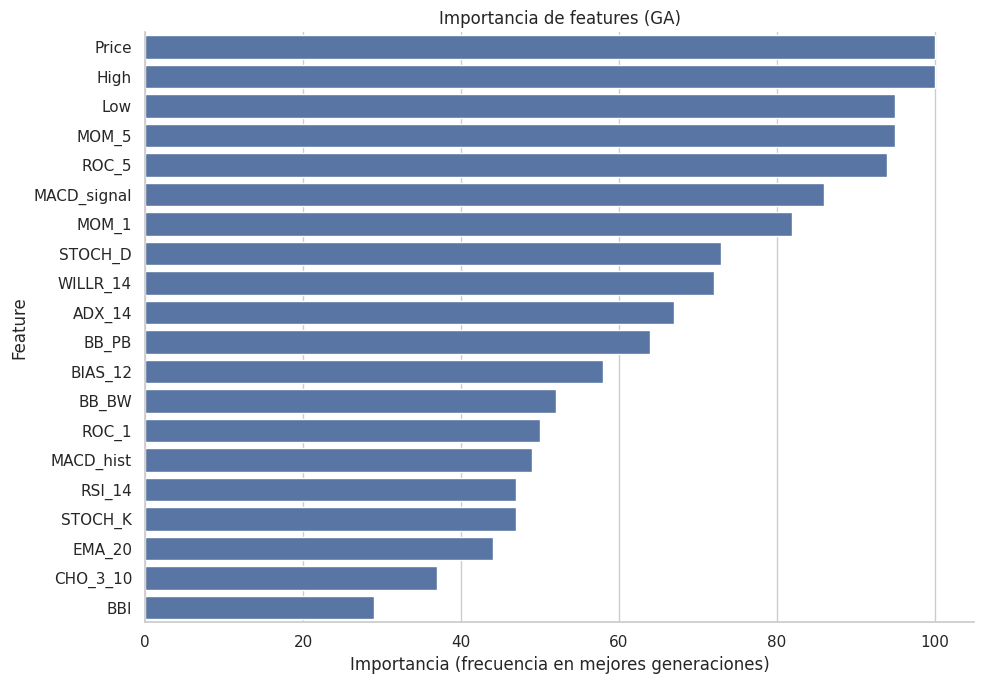

In [9]:


top_n = 20 # ajusta a gusto
plot_df = ranking_aapl.sort_values(ascending=False).head(top_n).reset_index()
plot_df.columns = ["feature", "importance"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, max(4, int(top_n*0.35))))
ax = sns.barplot(data=plot_df, x="importance", y="feature")
ax.set(
    title="Importancia de features (GA)",
    xlabel="Importancia (frecuencia en mejores generaciones)",
    ylabel="Feature"
)
sns.despine()
plt.tight_layout()
plt.show()

In [10]:
symbol_to_path = {
    "AAPL": "Dataset/Stocks/aapl.us.txt",
    "GE": "Dataset/Stocks/ge.us.txt",
    "BA":"Dataset/Stocks/ba.us.txt",
}

df_multi = run_multi_asset_report(
    symbol_to_path=symbol_to_path,
    start_date="2000-01-01",
    end_date="2010-12-31",
    ks=(5, 10, 20, 30),
    lookbacks=(5,),
    runs=3,
    ga_cfg=GAConfig(
        pop_size=100,
        p_crossover=0.8,
        p_mutation=0.003,
        generations=100,
        n_points_cx=4,
        elitism=0,
        min_features=3,
        n_splits_cv=5,
        random_state=123,
    ),
    train_ratio=0.7,
    val_ratio=0.1,
)

# Mostrar resumen completo de todos los resultados
display_results_summary(df_multi)

# También mostrar tabla completa bien formateada
print("\n" + "=" * 100)
print("TABLA COMPLETA DE TODOS LOS RESULTADOS")
print("=" * 100)
display_table_all = display_results_table(df_multi, sort_by="test_rmse_real", ascending=True)
print(display_table_all.to_string(index=False))


RESUMEN DE RESULTADOS

SYMBOL: AAPL

🏆 Mejor modelo (menor test RMSE): Naive (lookback=5, k=-)
   Test RMSE: 0.4759 USD | Test MSE: 0.000710

📊 Resumen por modelo:
                test_rmse_real              val_rmse_real               \
                          mean      min std          mean      min std   
modelo                                                                   
GA-LSTM (k=10)          0.9789   0.9789 NaN        0.8677   0.8677 NaN   
GA-LSTM (k=20)          1.1896   1.1896 NaN        0.9854   0.9854 NaN   
GA-LSTM (k=30)          1.3036   1.3036 NaN        1.0380   1.0380 NaN   
GA-LSTM (k=5)           1.0473   1.0473 NaN        0.9079   0.9079 NaN   
LSTM (todas)            1.4517   1.4517 NaN        1.0001   1.0001 NaN   
Naive                   0.4759   0.4759 NaN        0.5669   0.5669 NaN   
PCA-SVR (todas)        17.9582  17.9582 NaN       10.1303  10.1303 NaN   
RF (todas)             11.3849  11.3849 NaN        4.3816   4.3816 NaN   

                test_